# 2. Loc 2:  Single-Facility Location
`ISE 754, Fall 2024`

__Package Used:__ Functions from the following package are used in this notebook for the first time: 

* `Optim`: [Optim.jl Reference](http://julianlsolvers.github.io/Optim.jl/stable/)
 

## 1. Nonlinear Optimization
_Nonlinear optimization_ refers to the problem of optimizing an objective function, where the elements of the objective function are points in a subset of Euclidean space. _Unconstrained nonlinear optimization_ is when there are no constraints on the possible solutions, and when there are constraints, it is more commonly referred to as _nonlinear programming_; _linear programming_ is when the objective function and constraints are all linear. _Mathematical programming_ refers to nonlinear and linear programming.

_Multivariate optimization_ corresponds to the optimization of a function of two or more variables and is the most flexible type of nonlinear optimization.

$ \begin{eqnarray*} \quad
\mathbf{x}^* &=& \mathrm{arg}\underset{\mathbf{x}}{\operatorname{min}} \bigl\{ f(\mathbf{x}) \bigr\} \\
T\!C^* &=& f(\mathbf{x}^*)
\end{eqnarray*}$

Procedures for unconstrained multivariate optimization differ with respect to whether they require information regarding the gradient, where the gradient is the multivariate version of the derivative. The Nelder Mead method (1965) is the most used most efficient _direct_, or gradient-free, method available, in contrast to _gradient-based_ methods that require gradients to be either provided or estimated, which can be difficult or impossible for some functions. Gradient-based methods are typically only used when working in high-dimensional spaces, which is common when, for example, training a neural network. 

## 2. Ex: Minisum Distance Location to Three Points
Given three points, find a point that minimizes the sum of the distances from that point to the other three points. This point is termed the _Steiner point_ and is characterized by all the angles from the point to the other three points being 120ᵒ.

Continuing with the example and `d2` one-liner from *1. Intro 2* and using the `unzip` and `dcf` one-liners from *2. Loc 1*:

In [1]:
d2(x1, x2) = length(x1) == length(x2) ? sqrt(sum((x1 .- x2).^2)) : 
    error("Inputs not same length.")
unzip(x) = collect.(zip(x...))
dcf() = display(current_figure())

pt = [(1, 1), (6, 1), (6, 5)]
xy = (3, 1)
d2.([xy], pt)

3-element Vector{Float64}:
 2.0
 3.0
 5.0

The function `optimize` performs general-purpose multivariate optimization. An initial location `x0` is specified, from which the function determines the location `x` that minimizes the sum of distances to each point in `pt`:

In [2]:
using Optim

x0 = [0.0, 0.0]   # Note: has to be a 2-vector of real numbers
optimize(x -> sum(d2.([x], pt)), x0)

 * Status: success

 * Candidate solution
    Final objective value:     8.697184e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    45
    f(x) calls:    89


In [3]:
res = optimize(x -> sum(d2.([x], pt)), x0)   # `res` is a named tuple of results
@show TCᵒ = res.minimum                      # Type `TC\^o<TAB>
xᵒ = res.minimizer

TC° = res.minimum = 8.697184389632483


2-element Vector{Float64}:
 5.089389040930581
 1.9663250607367784

In [4]:
res.f_calls   # Type `res.<TAB>` to see and select all results

89

In order to make the optimization code above more reusable for different types of objectives, will define a generic `TC` function:

In [5]:
TC(x) = sum(d2.([x], pt))
TC(xᵒ)

8.697184389632483

In [6]:
res = optimize(TC, x0)
@show TCᵒ = res.minimum
xᵒ = res.minimizer

TC° = res.minimum = 8.697184389632483


2-element Vector{Float64}:
 5.089389040930581
 1.9663250607367784

### Nelder-Mead in Action
Create a function `fargplot` to first plot the point `x` being evaluated and then return the result of evaluating the function `f` at `x`:

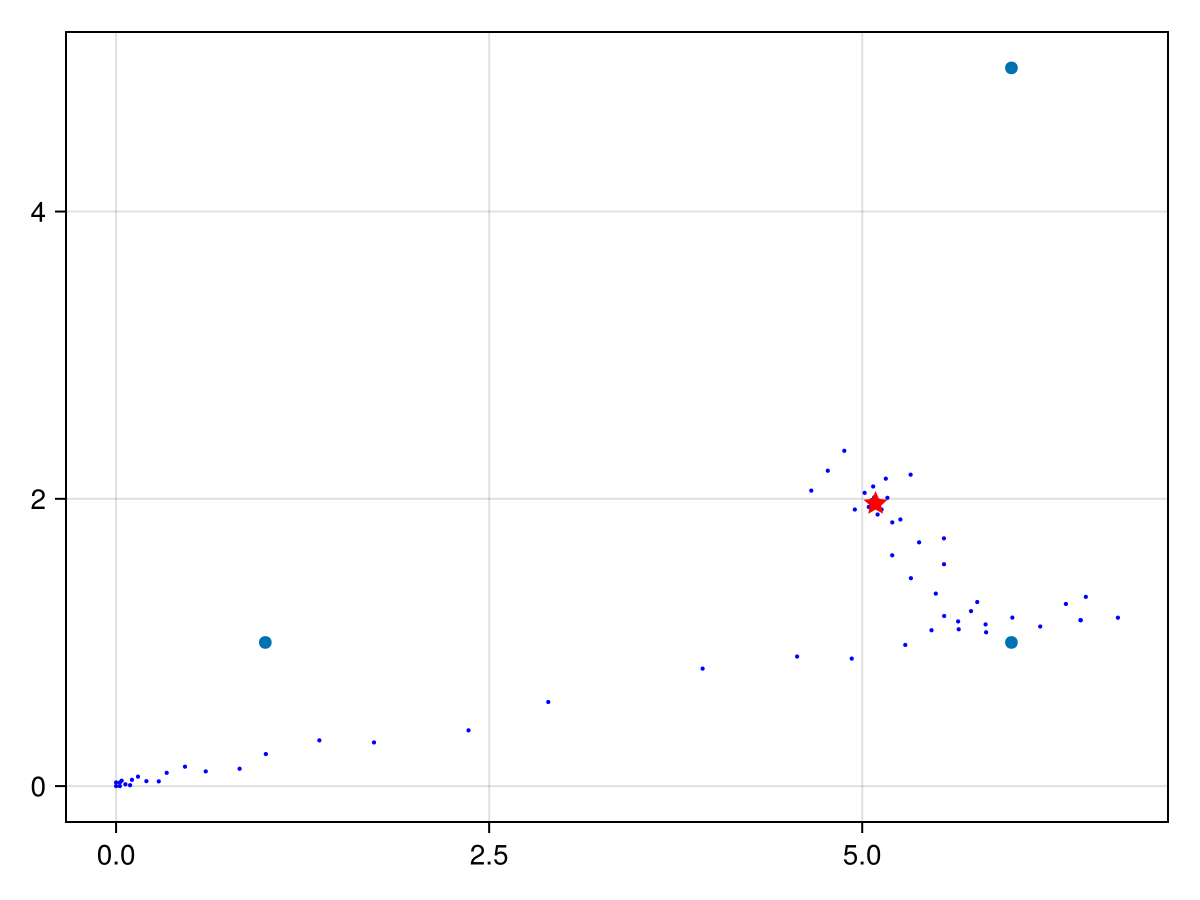

In [7]:
using CairoMakie

# function fargplot(f, x)
#     scatter!(x...; color = :blue, markersize = 3)
#     return f(x)
# end
# fargplot(f, x) = (scatter!(x...; color = :blue, markersize = 3); f(x))   # One-liner
fargplot(f, x, kwargs) = (scatter!(x...; kwargs...); f(x))   # One-liner

scatter(unzip(pt)...)
kwargs1 = (; color = :blue, markersize = 3)
x0 = [0.0, 0.0]
xᵒ = optimize(x -> fargplot(TC, x, kwargs1), x0).minimizer
kwargs2 = (; color = :red, marker = :star5, markersize = 14)
scatter!(xᵒ...; kwargs2...)
dcf();

Numerically estimate gradient using `BFGS` quasi-Newton method:

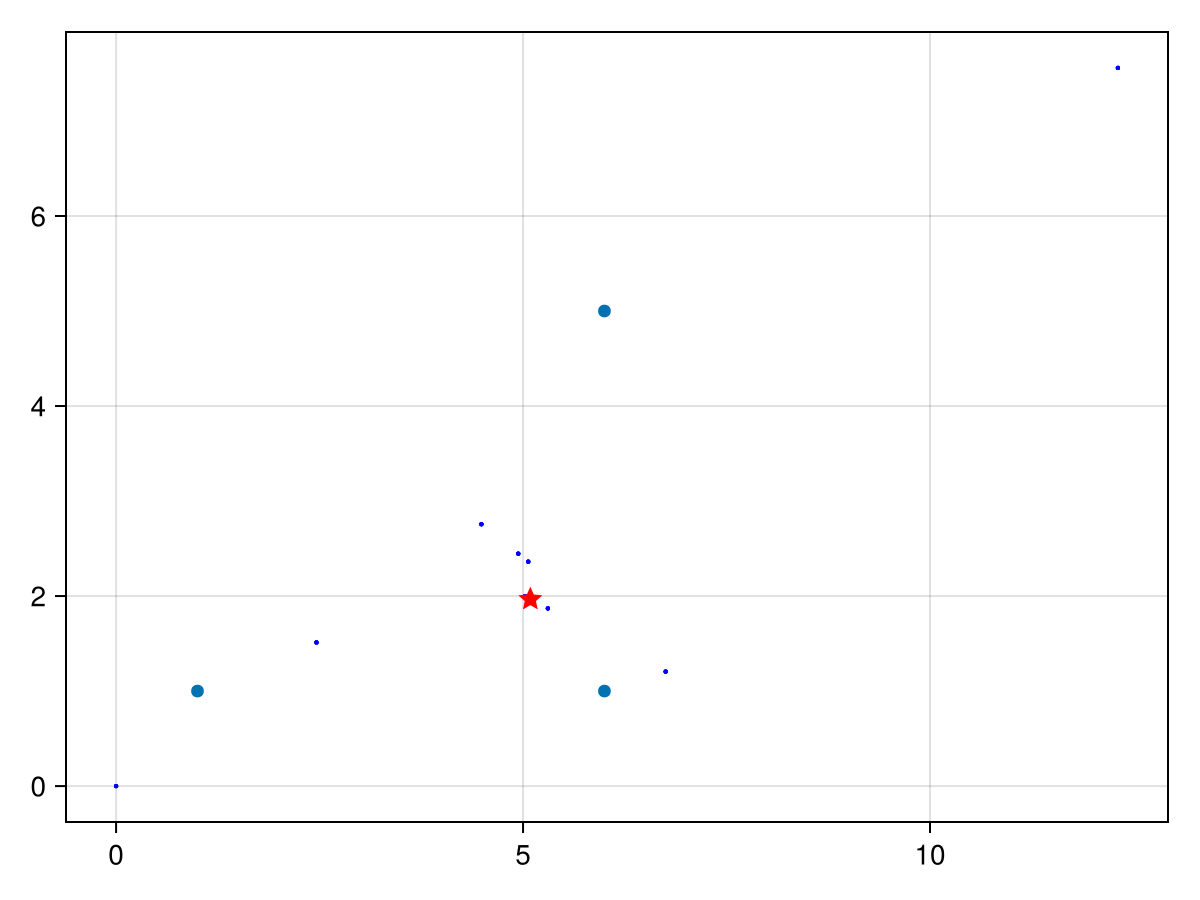

In [8]:
scatter(unzip(pt)...)
xᵒ = optimize(x -> fargplot(TC, x, kwargs1), x0, BFGS()).minimizer
scatter!(xᵒ...; kwargs2...)
dcf();

__Compare:__
* Nelder-Mead (direct, no gradients)
* LBFGS with numerical gradients estimated via finite differences
* LBFGS with automatic differentiation (AD) of code in `TC`

In [9]:
TC2(x) = 
    sin(5 * x[1] * x[2]) * exp(-x[3]^2 / 2) +
    log(1 + x[1]^6 + x[2]^6 + 1e-8) +
    atan(x[1] * x[2] + x[3]) / (1 + cos(3 * x[3]) + 1e-8) +
    1 / (1 + (x[1] - 1)^2 + 1000 * (x[2] - 2)^2)
x02 = [1.5, 2.5, 0.0]
optimize(TC2, x02)

 * Status: success

 * Candidate solution
    Final objective value:     -1.570796e+08

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    467
    f(x) calls:    959


In [10]:
optimize(TC2, x02, LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     -1.570791e+08

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.10e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.12e-14 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.77e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    59
    f(x) calls:    402
    ∇f(x) calls:   402


In [11]:
optimize(TC2, x02, LBFGS(); autodiff = :forward)

 * Status: success

 * Candidate solution
    Final objective value:     -1.570794e+08

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.21e+01 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    25
    f(x) calls:    219
    ∇f(x) calls:   219


### Contour and Surface Plots

In [12]:
xrng = 0:0.1:7
yrng = 0:0.1:6
Z = [sum(d2.([(x, y)], pt)) for x in xrng, y in yrng]

71×61 Matrix{Float64}:
 15.3072  15.1591  15.0175  14.883   …  18.4676  18.6399  18.8147  18.992
 15.0632  14.9105  14.7641  14.6248     18.27    18.4436  18.6196  18.7982
 14.8239  14.6663  14.5149  14.3704     18.0749  18.2497  18.427   18.6068
 14.5899  14.4274  14.2707  14.1206     17.8825  18.0585  18.237   18.418
 14.3621  14.1946  14.0325  13.8765     17.6927  17.8698  18.0496  18.2318
 14.1412  13.9689  13.8013  13.6392  …  17.5055  17.6838  17.8647  18.0481
 13.9282  13.7511  13.5783  13.4103     17.3211  17.5005  17.6826  17.8671
 13.7238  13.5426  13.365   13.1914     17.1394  17.3199  17.5031  17.6888
 13.529   13.3442  13.1625  12.9842     16.9604  17.1421  17.3263  17.5132
 13.3442  13.1568  12.9722  12.7903     16.7843  16.967   17.1523  17.3402
 13.1701  12.9811  12.7947  12.611   …  16.611   16.7947  16.9811  17.1701
 13.0067  12.8172  12.6304  12.4466     16.4405  16.6252  16.8126  17.0027
 12.854   12.6649  12.4791  12.2967     16.2729  16.4586  16.647   16.8381
  ⋮ 

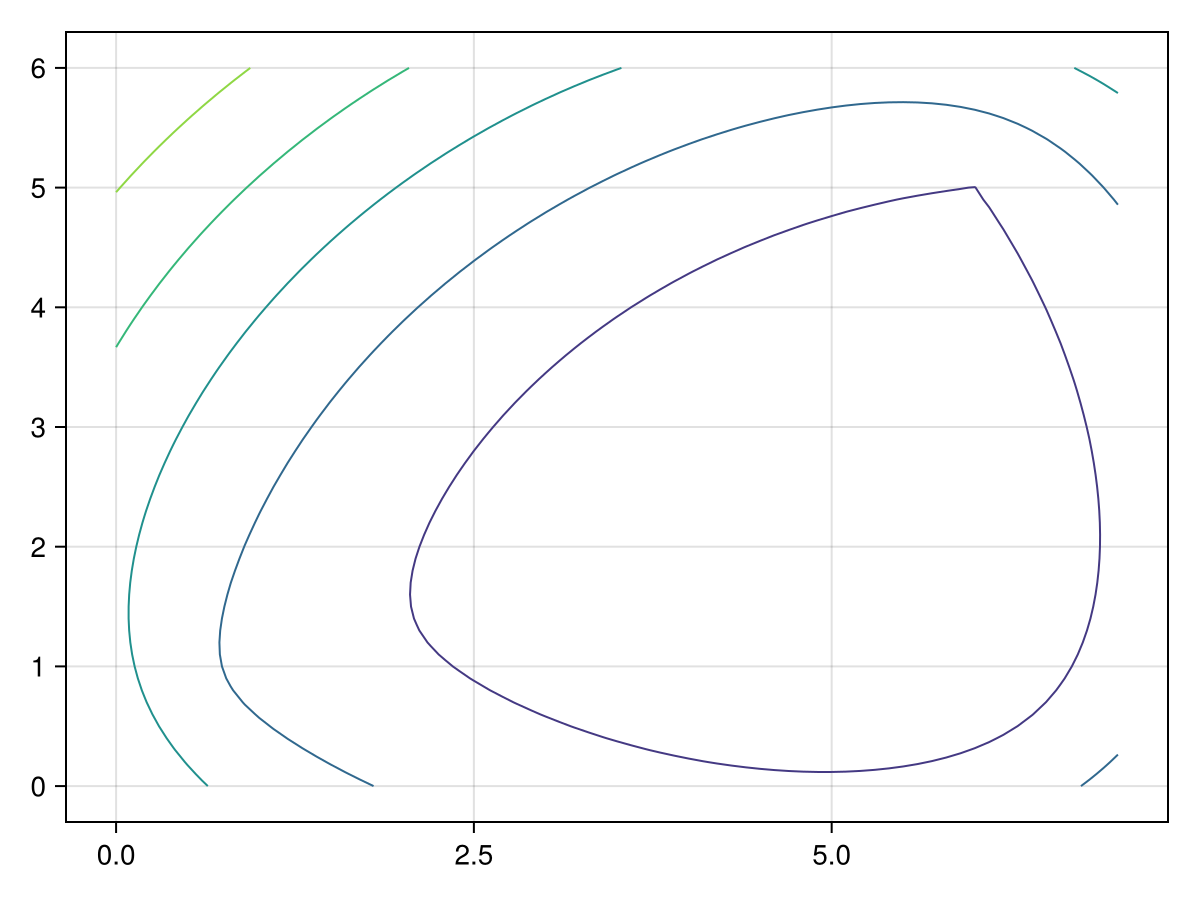

In [13]:
contour(xrng, yrng, Z)

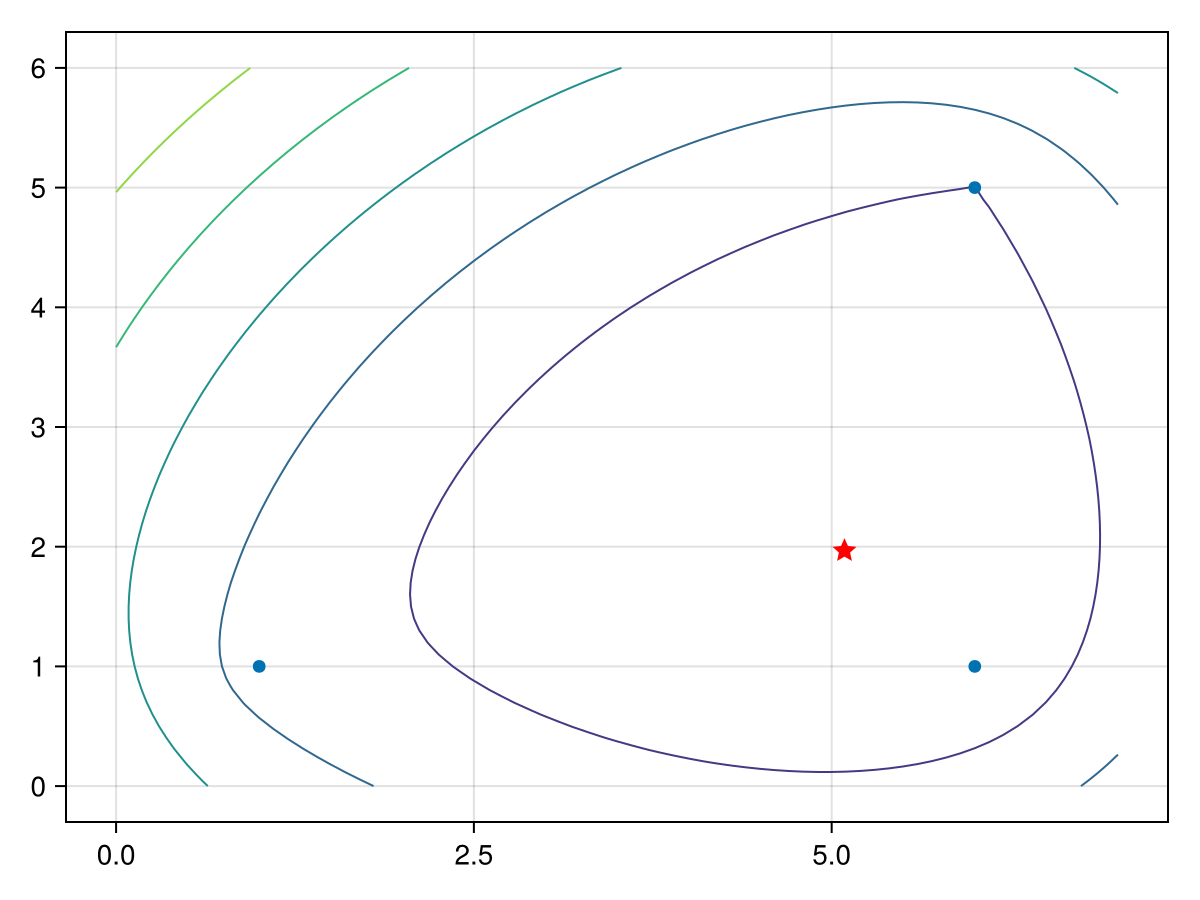

In [14]:
scatter!(unzip(pt)...)
scatter!(xᵒ...; kwargs2...)
dcf();

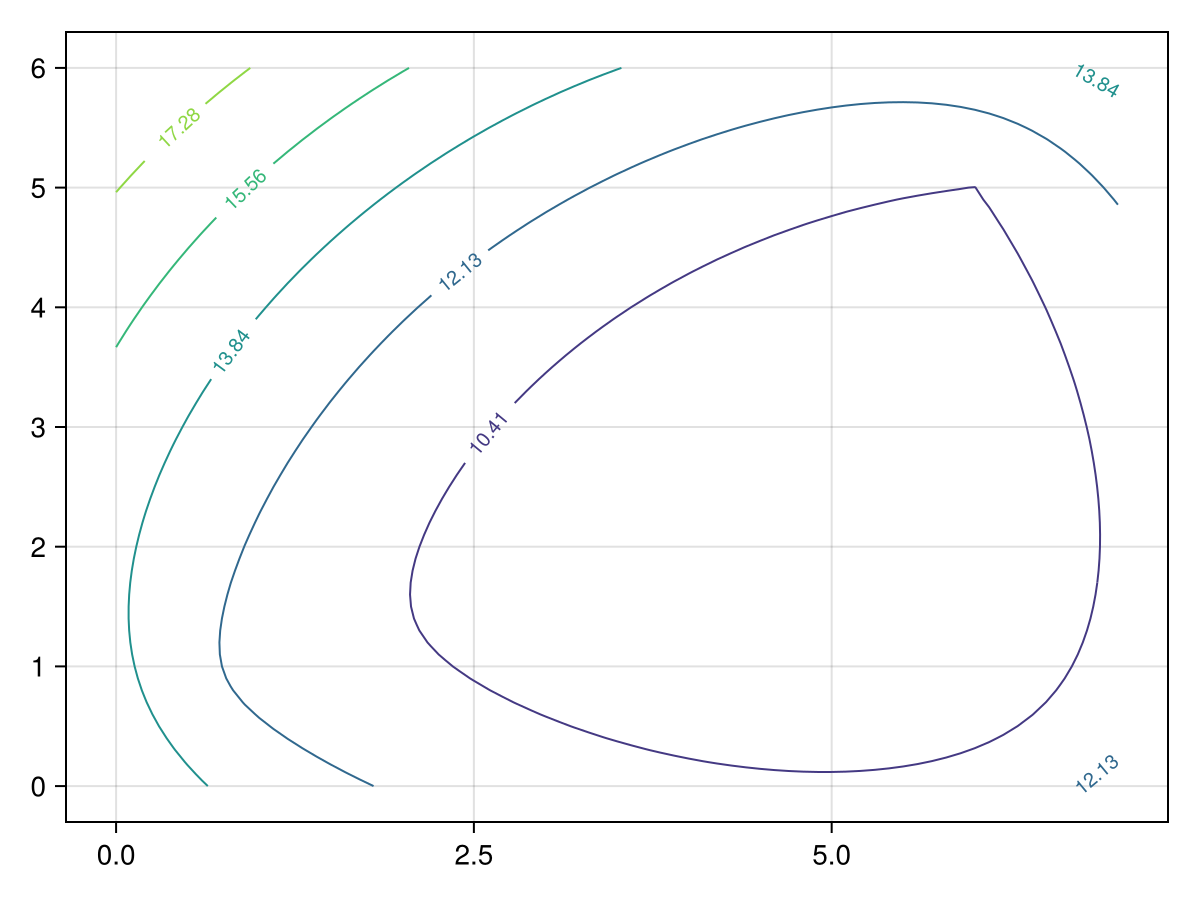

In [15]:
contour(xrng, yrng, Z; labels = true)

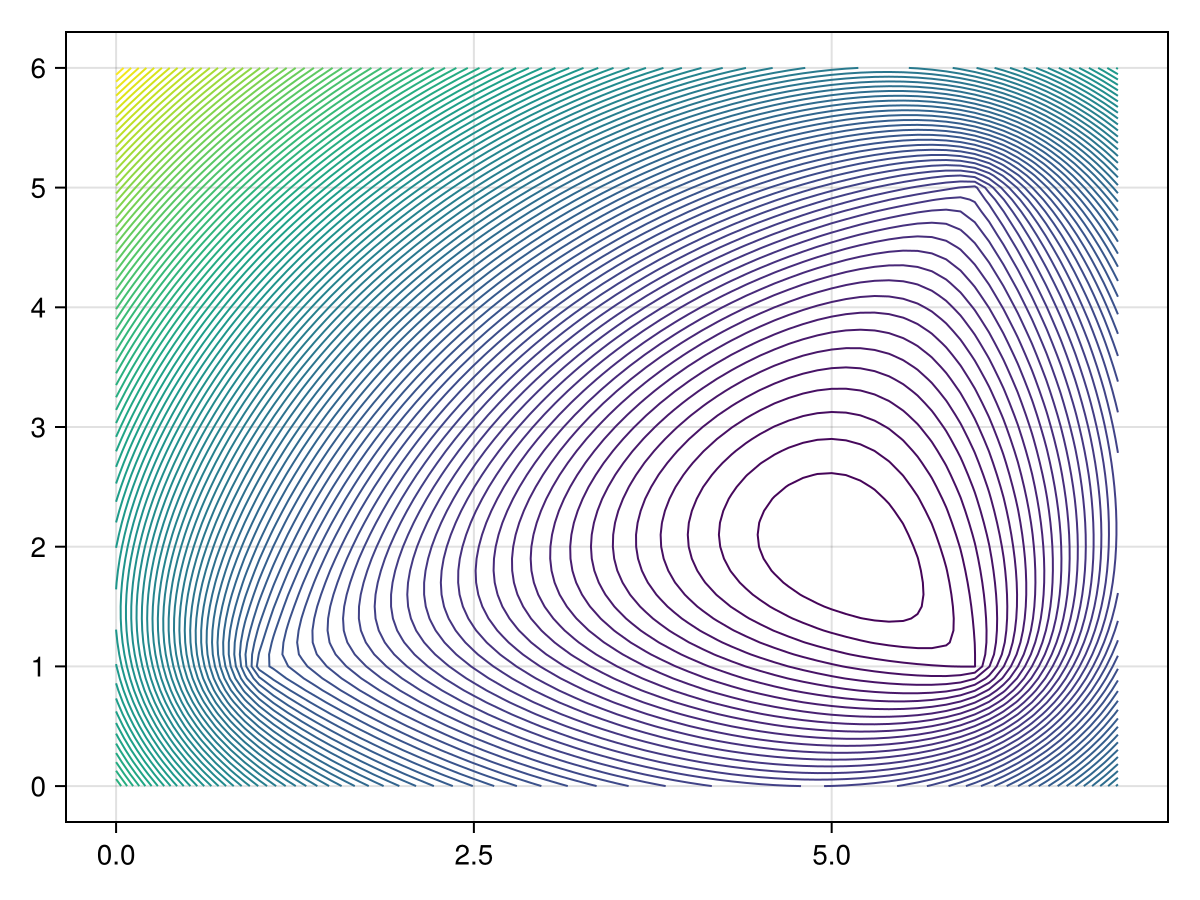

In [16]:
contour(xrng, yrng, Z; levels = 100)

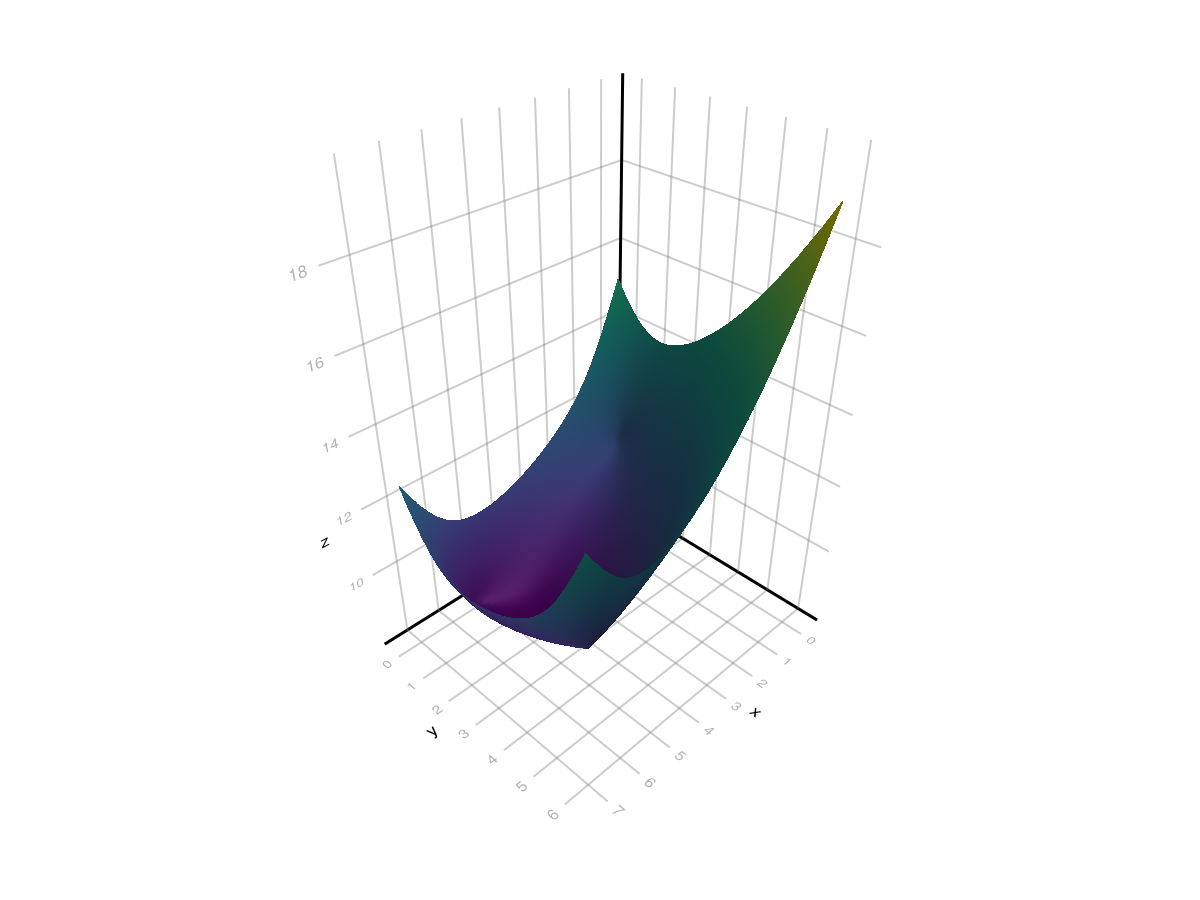

In [17]:
surface(xrng, yrng, Z)

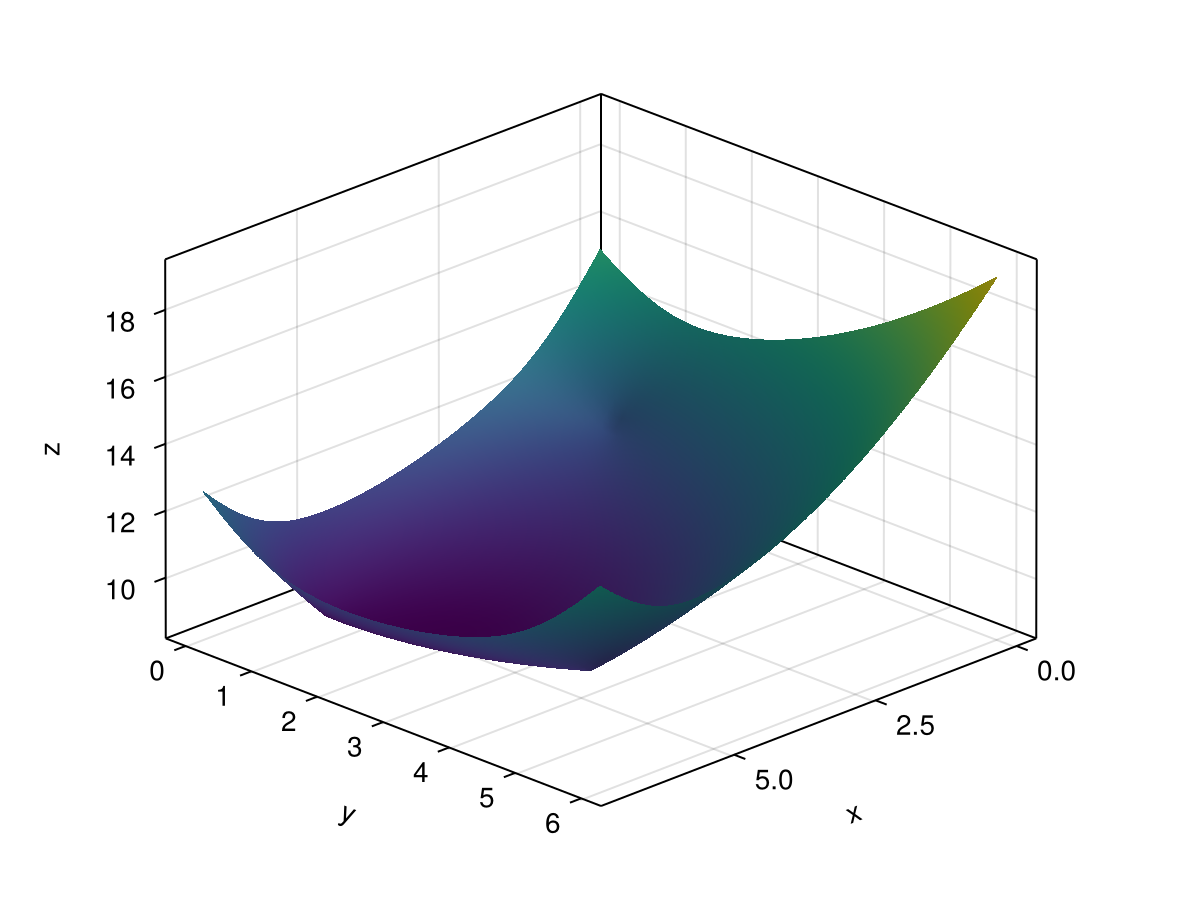

In [18]:
surface(xrng, yrng, Z; axis=(type=Axis3, azimuth = pi/4))

### Picking a Starting Point
#### Use a Random Point
Generate a random point anywhere within the rectangle region enclosing the points in `pt`:

In [19]:
x,y = unzip(pt)

2-element Vector{Vector{Int64}}:
 [1, 6, 6]
 [1, 1, 5]

In [20]:
xmn, xmx = extrema(x)                 # Returns min and max values
ymn, ymx = extrema(y)

(1, 5)

In [21]:
using Random
Random.seed!(1234)    # Set seed if what to allow replication
x0 = [xmn + rand()*(xmx - xmn), ymn + rand()*(ymx - ymn)]

2-element Vector{Float64}:
 2.6298836443179745
 3.1962045452622676

In [22]:
x0 = [xmn + rand()*(xmx - xmn), ymn + rand()*(ymx - ymn)]

2-element Vector{Float64}:
 2.092933274094153
 4.576981712803953

In [23]:
res = optimize(TC, x0)
@show TCᵒ = res.minimum
xᵒ = res.minimizer

TC° = res.minimum = 8.697184392151266


2-element Vector{Float64}:
 5.089715837135104
 1.9663602134284583

#### Use the Mean
Find the mean of the points in `pt`:

In [24]:
using Statistics
x0 = mean(unzip(pt))      # What happened?

3-element Vector{Float64}:
 1.0
 3.5
 5.5

In [25]:
x0 = mean.(unzip(pt))

2-element Vector{Float64}:
 4.333333333333333
 2.3333333333333335

In [26]:
res = optimize(TC, x0)
@show TCᵒ = res.minimum
xᵒ = res.minimizer

TC° = res.minimum = 8.697184381044615


2-element Vector{Float64}:
 5.089566905043874
 1.9662907621468446

---
#### __Question 2.2.1__
Why did we keep getting the same `xᵒ` and `TCᵒ` for all the `x0` used: `[0.0, 0.0]`, random, and the mean of `pt`? If so, why?

(a) Yes, because the objective function is linear.

(b) No, the `xᵒ` and `TCᵒ` differ after the first few fractional digits.

(c) Yes, because the objective function is concave.

(d) Yes, because the objective function is convex.

---

## 3. Minimax Location

In [27]:
d2.([x0], pt)

3-element Vector{Float64}:
 3.5901098714230026
 2.13437474581095
 3.1446603773522015

In [28]:
maximum(d2.([x0], pt))

3.5901098714230026

In [29]:
using Statistics

TC(x) = maximum(d2.([x], pt))
x0 = mean.(unzip(pt))
res = optimize(TC, x0)
@show TCᵒ = res.minimum
xᵒ = res.minimizer

TC° = res.minimum = 3.2015621668925127


2-element Vector{Float64}:
 3.5002844051451856
 2.9996444682714216

In [30]:
d2.([xᵒ], pt)

3-element Vector{Float64}:
 3.2015621352865713
 3.2011179382598285
 3.2015621668925127

In [31]:
d2.([x0], pt)

3-element Vector{Float64}:
 3.5901098714230026
 2.13437474581095
 3.1446603773522015

In [32]:
maximum(d2.([x0], pt))

3.5901098714230026

## 4. Maximin Location

In [33]:
using Statistics

TC(x) = -minimum(d2.([x], pt))   # Using minus sign to convert min to max objective
x0 = mean.(unzip(pt))
res = optimize(TC, x0)
@show TCᵒ = res.minimum
xᵒ = res.minimizer

TC° = res.minimum = -Inf


2-element Vector{Float64}:
 -1.517615888912572e154
  6.956743000806962e153

In [34]:
optimize(TC, x0)                 # Unbounded solution

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     -Inf

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    2647


### Feasible Region

In [35]:
pt

3-element Vector{Tuple{Int64, Int64}}:
 (1, 1)
 (6, 1)
 (6, 5)

In [36]:
r = [(0, 0), (7, 6)]   # SW and NE corners of feasible region
isinrect(x, r) = r[1][1] <= x[1] <= r[2][1] && r[1][2] <= x[2] <= r[2][2]
TC(x) = isinrect(x, r) ? -minimum(d2.([x], pt)) : Inf
TC([4, 4]), TC([8, 8])

(-2.23606797749979, Inf)

In [37]:
x0 = mean.(unzip(pt))
res = optimize(TC, x0)
@show TCᵒ = res.minimum
xᵒ = res.minimizer

TC° = res.minimum = -5.000215777483092


2-element Vector{Float64}:
 0.9535476404731719
 5.999999999968523

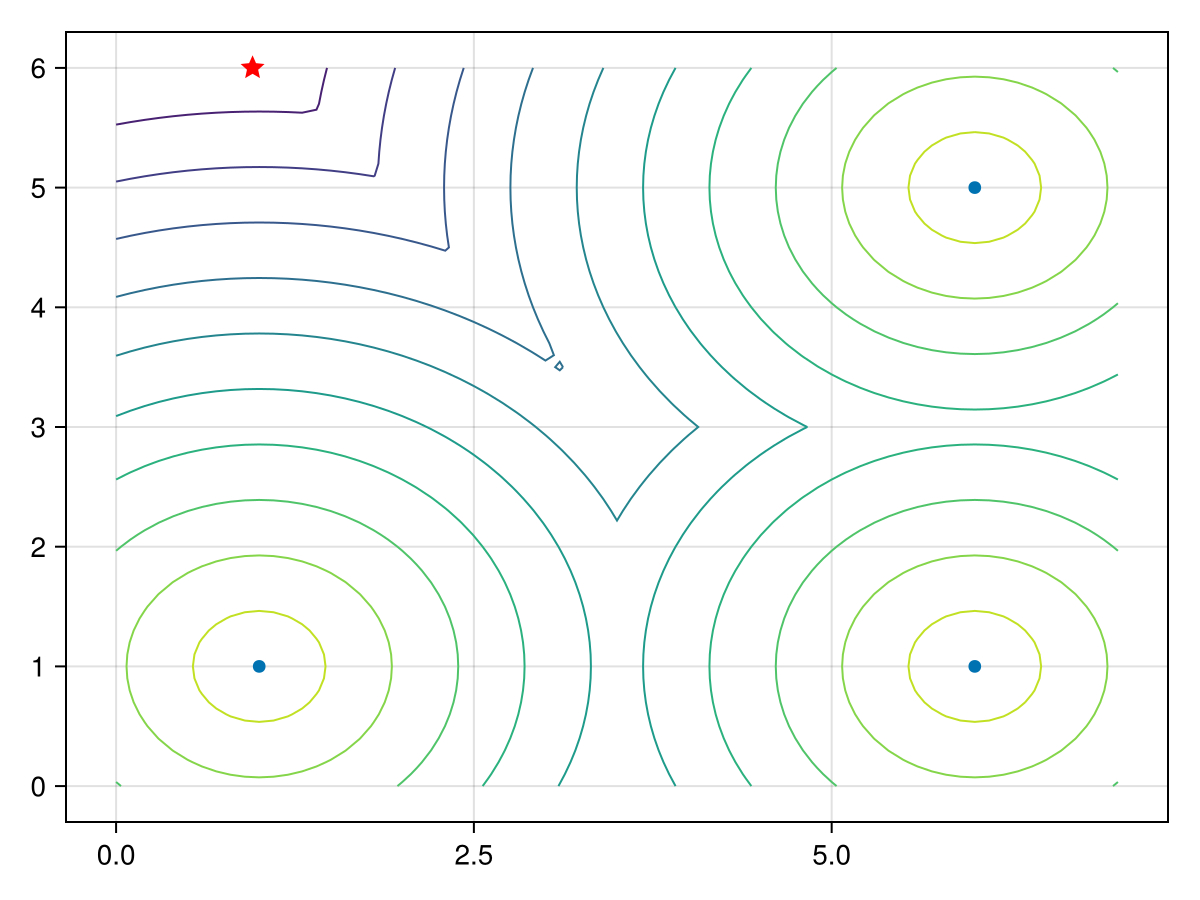

In [38]:
xrng = r[1][1]:0.1:r[2][1]
yrng = r[1][2]:0.1:r[2][2]
Z = [TC((x, y)) for x in xrng, y in yrng]
contour(xrng, yrng, Z; levels = 10)
scatter!(unzip(pt)...)
scatter!(xᵒ...; kwargs2...)
dcf();

## 5. Create Random Points within a Rectangle
Create ten random (real-number) points in the region defined by the rectangle `[(1,2), (6, 10)]` using the random number seed `2024`. 

Note: `_` is used as a placeholder for the index variable since it is not used in the comprehension.

In [39]:
using Random

Random.seed!(2024)

r = [(1,2), (6,10)] 
(xmn, ymn), (xmx, ymx) = r
pt = [(xmn + rand()*(xmx - xmn), ymn + rand()*(ymx - ymn)) for _ in 1:10]

10-element Vector{Tuple{Float64, Float64}}:
 (1.5442122969918628, 7.751225302763124)
 (3.913331098480076, 9.448466350616748)
 (2.669962624876029, 7.023774625975537)
 (1.998618977761716, 9.50962279502427)
 (1.494820119581424, 4.619282862392633)
 (1.5355391250253287, 7.454294643168344)
 (1.0266170790624576, 3.743403401039598)
 (1.1917626981334974, 5.876468828900364)
 (3.842555588788429, 7.071119870548661)
 (3.6179184357105316, 3.899509086278761)

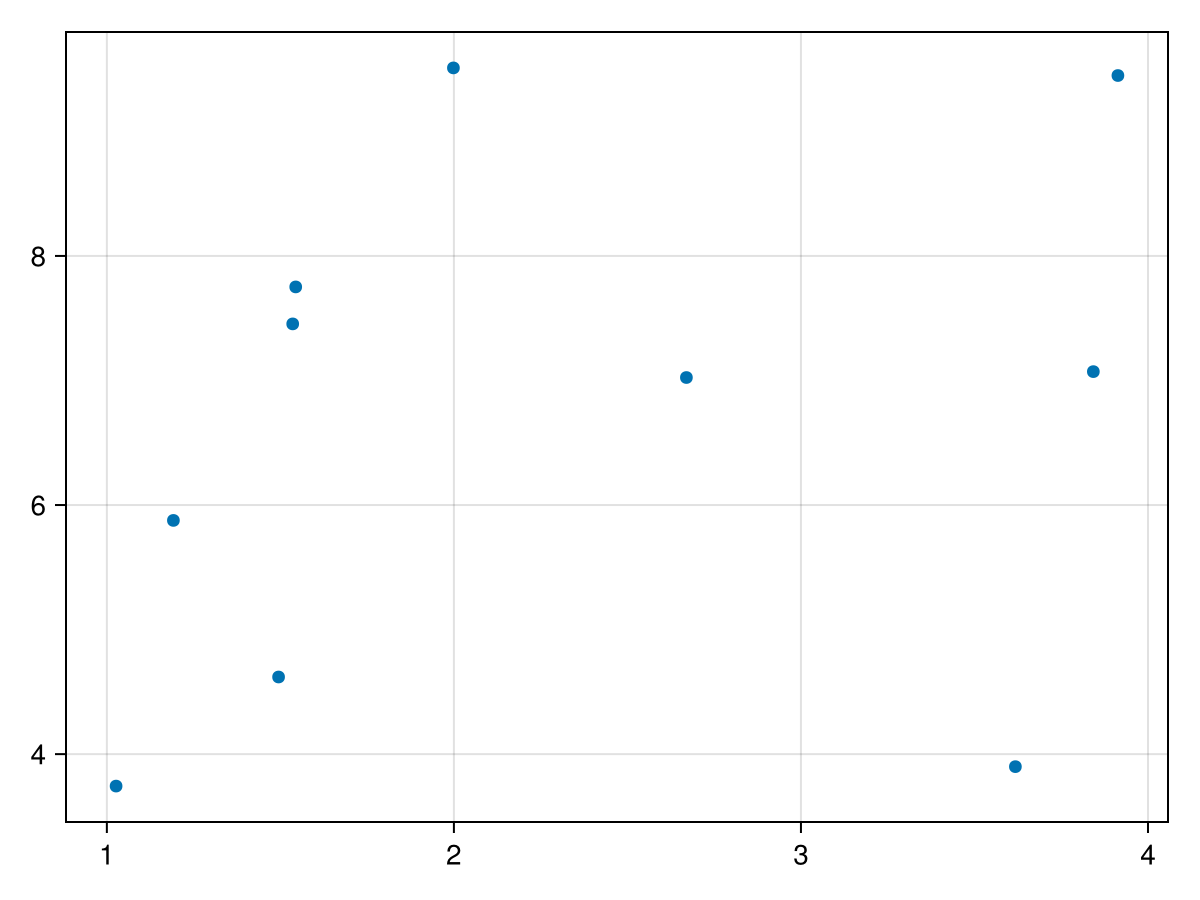

In [40]:
using CairoMakie

unzip(x) = collect.(zip(x...))
dcf() = display(current_figure())

scatter(unzip(pt)...)
dcf();

### Plot Polygon
The rectangle `[(2, 6), (3,8)]` can be plotted as the polygon `[(2, 6), (3, 6), (3,8), (2, 8)]`:

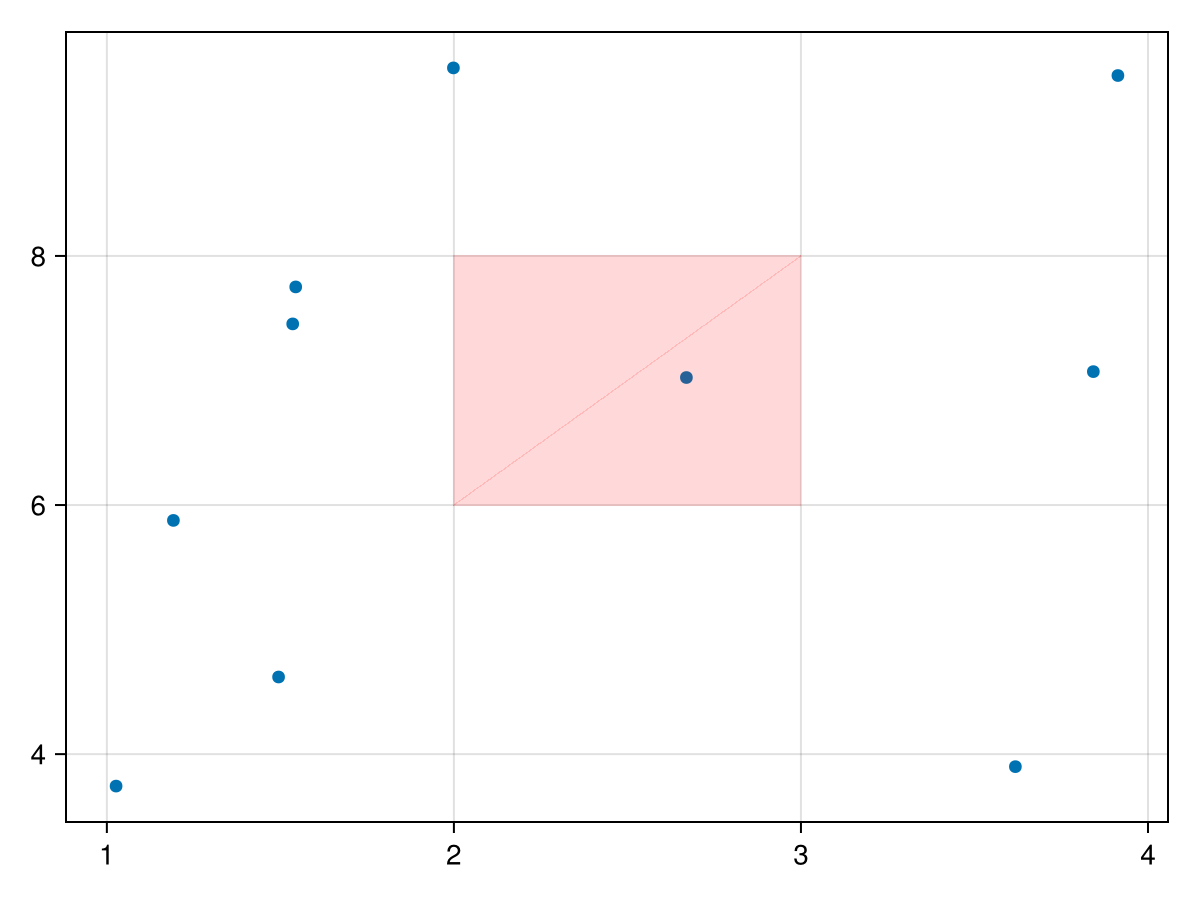

In [41]:
p = [(2, 6), (3, 6), (3,8), (2, 8)]
poly!(p; color = (:red, 0.15))  # alpha = 0.15, controls degree of transparency
dcf();